In [1]:
print('This is for code used in the main analysis')

This is for code used in the main analysis


In [12]:
#libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Kmeans libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl as cmpl
import matplotlib.patches as mpatches

In [3]:
os.chdir("..")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[53.35604136 -6.27203773]
 [53.34108627 -6.24685977]
 [53.34365711 -6.29759778]]


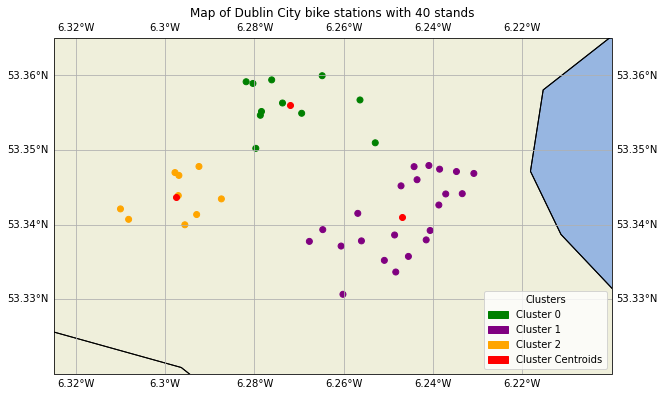

In [20]:
# Choose stations using K-means clustering 

# Import station coordinates (pre-wrangled in R)
df = pd.read_csv("data/stations.csv")

# Filter the dataframe to include only bike stands = 40
df = df[df['BIKE.STANDS'] == 40]

# Create a subset of the dataset containing only the latitude and longitude columns
X = df[['LATITUDE', 'LONGITUDE']]

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_std)

# Add the cluster labels to the dataframe
df['CLUSTER'] = kmeans.labels_

# Print the centroids of each cluster
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print(centroids)

# Create a scatter plot of the data points colored by cluster
proj = ccrs.Mercator()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=proj))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
x0, y0 = -6.27203773, 53.35604136
ax.plot(x0, y0, 'ro', transform=ccrs.PlateCarree())
x1, y1 = -6.24685977, 53.34108627
ax.plot(x1, y1, 'ro', transform=ccrs.PlateCarree())
x2, y2 = -6.29759778, 53.34365711
ax.plot(x2, y2, 'ro', transform=ccrs.PlateCarree())
colours = {0:'green', 1:'purple', 2:'orange', 'Centroids':'red'}
ax.scatter(df['LONGITUDE'], df['LATITUDE'], c = df['CLUSTER'].map(colours),transform=ccrs.PlateCarree())
ax.set_extent([-6.325, -6.2, 53.32, 53.365], crs=ccrs.PlateCarree())
ax.set_title('Map of Dublin City bike stations with 40 stands')
ax.gridlines(draw_labels=True)
ax.legend(loc='lower right', frameon=True, title='Clusters')
patches = [mpatches.Patch(color=color, label=f'Cluster {cluster}')
           for cluster, color in colours.items()]
ax.legend(handles=patches, loc='lower right', frameon=True, title='Clusters')



In [14]:
# Find the nearest point to each cluster
distances = cdist(X, centroids, 'euclidean')
nearest_centroid_indices = np.argpartition(distances, kth=range(3))[:, :3]

# Get the nearest point to each cluster
nearest_points = []
for i in range(kmeans.n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    nearest_point_index = np.argmin(distances[cluster_indices, i])
    nearest_point = X.iloc[cluster_indices[nearest_point_index]]
    nearest_points.append(nearest_point)

# Print the nearest point to each cluster
print(nearest_points)

[LATITUDE     53.356308
LONGITUDE    -6.273717
Name: 107, dtype: float64, LATITUDE     53.338615
LONGITUDE    -6.248606
Name: 111, dtype: float64, LATITUDE     53.343899
LONGITUDE    -6.297060
Name: 93, dtype: float64]


Consulting the indices for the above coordinates shows that geographically well-distributed stations are: 
1. Phibsborough Road
2. Merrion Square South 
3. Royal Hospital

In [15]:
#import data
data = pd.read_csv("data/bikedata.csv")
data.head()

,Unnamed: 0,TIME,NAME,BIKE.STANDS,AVAILABLE.BIKE.STANDS,AVAILABLE.BIKES,STATUS
0,1,2018-08-01 12:30:02,ROYAL HOSPITAL,40,40,0,Open
1,2,2018-08-01 12:35:02,ROYAL HOSPITAL,40,40,0,Open
2,3,2018-08-01 12:40:02,ROYAL HOSPITAL,40,40,0,Open
3,4,2018-08-01 12:45:02,ROYAL HOSPITAL,40,40,0,Open
4,5,2018-08-01 12:50:02,ROYAL HOSPITAL,40,40,0,Open


In [16]:
#Parse dates and times
data.TIME = pd.to_datetime(data.TIME, format = "%Y-%m-%d %H:%M:%S")
data["DATE"] = pd.DatetimeIndex(data.TIME.dt.date)
data.head()
#Calculate bike usage
data["BIKE.USAGE"] = data["AVAILABLE.BIKE.STANDS"]/data["BIKE.STANDS"]
data.head()

,Unnamed: 0,TIME,NAME,BIKE.STANDS,AVAILABLE.BIKE.STANDS,AVAILABLE.BIKES,STATUS,DATE,BIKE.USAGE
0,1,2018-08-01 12:30:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
1,2,2018-08-01 12:35:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
2,3,2018-08-01 12:40:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
3,4,2018-08-01 12:45:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
4,5,2018-08-01 12:50:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0


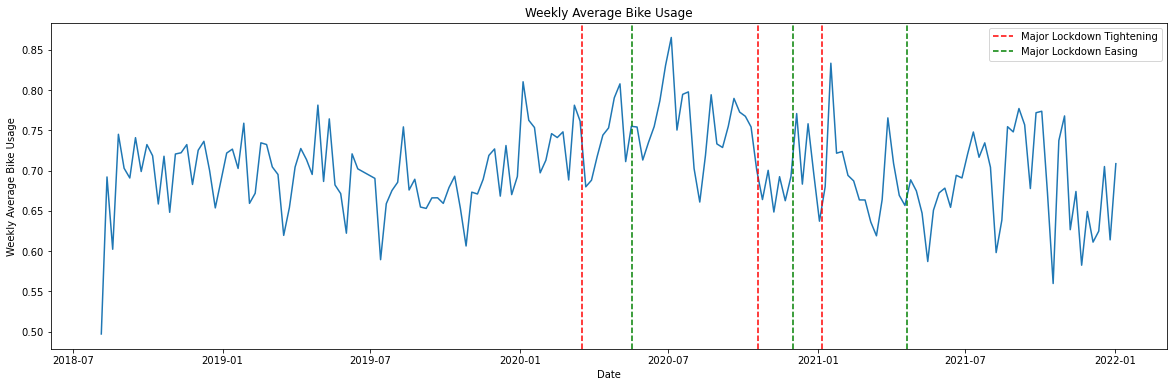

In [23]:
#Calculate weekly average usage
weekly_avg = data.groupby(pd.Grouper(key='DATE', freq='W'))['BIKE.USAGE'].mean()
date_vector = pd.DatetimeIndex(data["DATE"].dt.date)

#visualise the data
fig, axes = plt.subplots(figsize=(20,6))
sns.lineplot(x = weekly_avg.index, y = weekly_avg.values).set_title('Weekly Average Bike Usage')
#mark major tightening and loosening of restrictions
plt.axvline(pd.to_datetime('2020-03-17'), color='red', linestyle='--', label = 'Major Lockdown Tightening')
plt.axvline(pd.to_datetime('2020-05-18'), color='green', linestyle='--', label = 'Major Lockdown Easing')
plt.axvline(pd.to_datetime('2020-10-19'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2020-12-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2021-01-06'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2021-04-21'), color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Average Bike Usage')
plt.legend()

Pre-Pandemic Intercept: [0.68513153]
Pre-Pandemic Coefficient: [0.00026794]
Post-Pandemic Intercept: [0.8387338]
Post-Pandemic Coefficient: [-0.00099054]


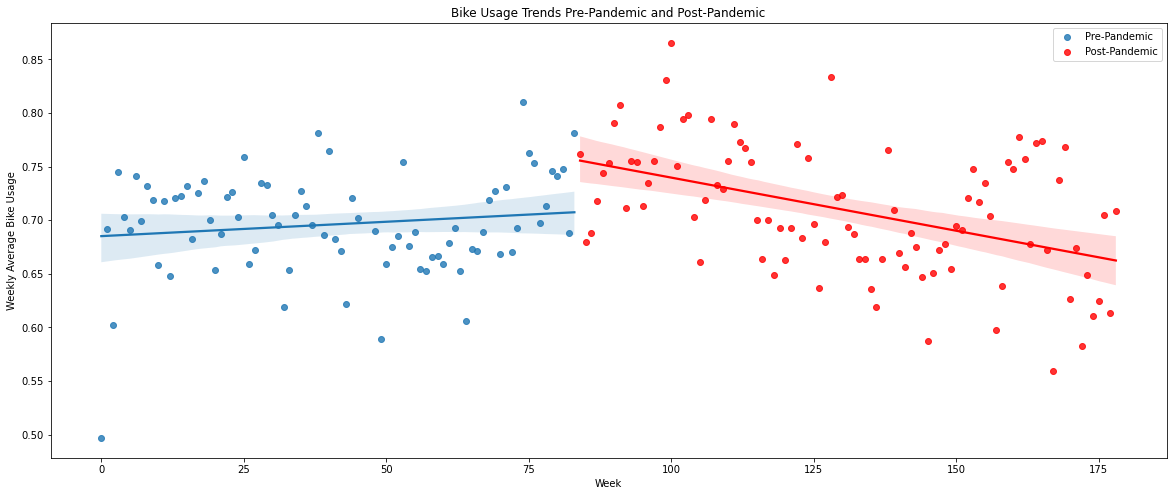

In [24]:
#TASK 1, PANDEMIC IMPACT
#Split the dataset into pre and post-pandemic dates
#cutoff date 15th of March 2020
data_pre_pandemic = weekly_avg[weekly_avg.index < '2020-03-15']
#convert dates to week numbers, time will be our only feature
dictpre = {'week': range(84), 'avg': data_pre_pandemic.values}
regressionpre = pd.DataFrame(data=dictpre)
#drop NaNs, 18 days of missing data in June 2019
regressionpre = regressionpre.dropna()
#post pandemic data
data_post_pandemic = weekly_avg[weekly_avg.index >= '2020-03-15']
dictpost = {'week': range(84, 179), 'avg': data_post_pandemic.values}
regressionpost = pd.DataFrame(data=dictpost)
regressionpost = regressionpost.dropna()

#reshape data for regression
preweek_arr = regressionpre.week.to_numpy().reshape(-1,1)
preavg_arr = regressionpre.avg.to_numpy().reshape(-1,1)
#run linear regression
pre_reg = LinearRegression().fit(preweek_arr,preavg_arr)
#print line parameters
print("Pre-Pandemic Intercept:", pre_reg.intercept_)
print("Pre-Pandemic Coefficient:", pre_reg.coef_[0])

postweek_arr = regressionpost.week.to_numpy().reshape(-1,1)
postavg_arr = regressionpost.avg.to_numpy().reshape(-1,1)
post_reg = LinearRegression().fit(postweek_arr,postavg_arr)
print("Post-Pandemic Intercept:", post_reg.intercept_)
print("Post-Pandemic Coefficient:", post_reg.coef_[0])

#visualise with regression plots
regFig, axes = plt.subplots(figsize=(20,8))
sns.regplot(x=regressionpre.week,y= regressionpre.avg, label = 'Pre-Pandemic')
sns.regplot(x=regressionpost.week,y= regressionpost.avg, color = 'red', label = 'Post-Pandemic').set_title('Bike Usage Trends Pre-Pandemic and Post-Pandemic')
plt.xlabel('Week')
plt.ylabel('Weekly Average Bike Usage')
plt.legend()

In [26]:
pre_avg_train, pre_avg_test, pre_week_train, pre_week_test = train_test_split(regressionpre.avg, regressionpre.week, test_size=0.2, random_state=42)

pre_avg_train_arr = pre_avg_train.array
pre_avg_test_arr = pre_avg_test.array
pre_week_train_arr = pre_week_train.array.to_numpy().reshape(-1,1)
pre_week_test_arr = pre_week_test.array.to_numpy().reshape(-1,1)


pre_reg = LinearRegression().fit(pre_week_train_arr, pre_avg_train_arr)

<class 'numpy.ndarray'>


Text(0, 0.5, 'Average Weekly Bike Usage')

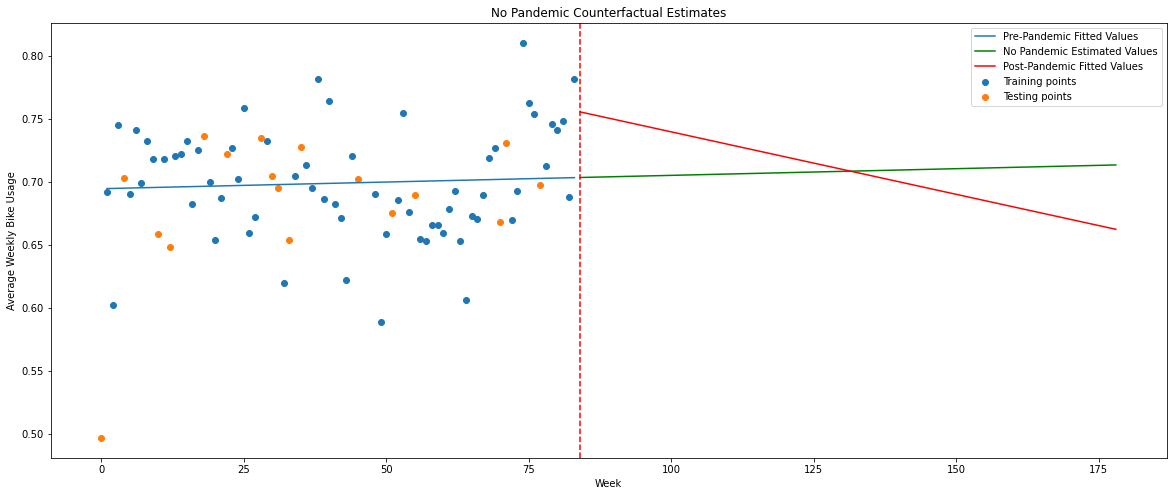

In [28]:
fc1 = np.array(range(1,84))
fc1_pred = pre_reg.predict(fc1.reshape(-1,1))
fc2 = np.array(range(84,179))
fc2_pred = pre_reg.predict(fc2.reshape(-1,1))

postfc = np.array(range(84, 179))
post_pred = post_reg.predict(postfc.reshape(-1,1))

predFig, axes = plt.subplots(figsize=(20,8))
plt.plot(fc1, fc1_pred, label = 'Pre-Pandemic Fitted Values')
plt.plot(fc2, fc2_pred, color = 'green', label = 'No Pandemic Estimated Values')
plt.plot(postfc, post_pred, color = 'red', label = 'Post-Pandemic Fitted Values')
dictmain = {'week': range(179), 'avg': weekly_avg.values}
plt.axvline(84, color='red', linestyle='--')
pred_df = pd.DataFrame(data=dictmain)
plt.scatter(pre_week_train_arr, pre_avg_train_arr, label='Training points')
plt.scatter(pre_week_test_arr, pre_avg_test_arr, label='Testing points')
plt.legend()
plt.title('No Pandemic Counterfactual Estimates')
plt.xlabel('Week')
plt.ylabel('Average Weekly Bike Usage')